# Codding Markov Chains Monte Carlo
# Awake model
Import required libraries and viisualize both datasets (sleep and waking data)

Sleep and Wake data are from Garmin indicating weather a person is asleep or awake based on motion sensing and heart rate

My objective is to use this data to create a model that returns the probability I am asleep at a given time. The final goal can be mathematically expressed as:

$$P(\text{awake} | \text{time})$$
In probability theory terms, this is the posterior probability I am awake given the time.




In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [2]:
# Data formatted in different notebook
wake_data = pd.read_csv('wake_data.csv')

# Labels for plotting
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']
wake_data.head(3)

,Unnamed: 0,indicator,time_offset
0,12/1/2017 5:00,1,-60
1,12/1/2017 5:01,1,-59
2,12/1/2017 5:02,1,-58


In [3]:
print('Number of sleep observations %d' % len(wake_data))

Number of sleep observations 11340


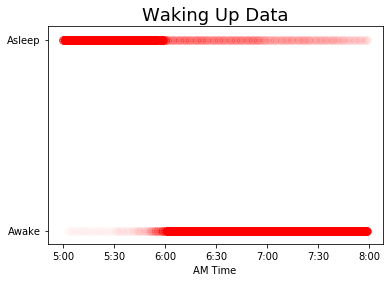

In [4]:
# visualize waking up data
# Sleep data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'r', edgecolors='r')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time'); 
plt.title('Waking Up Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

### PyMC3 Model

In [5]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'indicator'])

In [6]:
#pymc3 model
#pm.Model() - creates a new Model object which is a contrainer for the model random variables
#Following instantiation of the model, the subsequent specification of the model components 
#is performed inside a with statement:

#This creates a context manager, with our sleep_model as the context, that includes
#all statements until the indented block ends(see where ; is). This means all PyMC3 objects 
#introduced in 
#the indented code block below the with statement are added to the model behind the scenes.
#Absent this context manager idiom, we would be forced to manually associate each of the 
#variables with basic_model right after we create them. If you try to create a new random 
#variable without a with model: statement, it will raise an error since there is no obvious
#model for the variable to be added to.


with pm.Model() as awake_model:
    # Create the alpha and beta parameters
    #The first two  statements in the context manager:
    #We call the Normal constructor to create a random variable to use as a normal prior.
    #Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial 
    #and many others, are available in PyMC3.
    #select an initial set of values for alpha and beta, the parameters of the logistic regression
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    #We can create a deterministic variable similarly to how we create a stochastic variable.
    #We simply call up the Deterministic class in PyMC3 and pass in the function that we desire
    ## tt - Teano package similar to Numpy for calculations
    ## see formula above
    
    #2. randomly assign new values to alpha and beta based on the current state
    
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    #tell the model it is observations of the Bernoiuli variable
    #data is connected throw Bernoulli variable
    
    #3.check if new random values agree with the observations, if the do not, reject
    #the values and return to the previous state
    #if the do, accept the values as the new current state
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling as a sampling algorithm
    
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    
    #repeat steps 2 and 3 for the specified number of iterations
    awake_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains, 0 divergences: 100%|█| 11000/11000 [00:56<00:00, 193.51draws
The number of effective samples is smaller than 10% for some parameters.


In [7]:
#extract all data, in production of big data ~ first 50% of model would be skipped
# Extract the alpha and beta samples from multitrace which is output from sampling
alpha_samples = awake_trace["alpha"][5000:, None]
beta_samples = awake_trace["beta"][5000:, None]

In [8]:
print(alpha_samples)

[[-0.43377301]
 [-0.43377301]
 [-0.43377301]
 ...
 [-0.51993821]
 [-0.51993821]
 [-0.51993821]]


In [9]:
print(beta_samples)

[[0.04350379]
 [0.04350379]
 [0.04350379]
 ...
 [0.04220596]
 [0.04283938]
 [0.04283938]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000257E56C1508>,
      dtype=object)

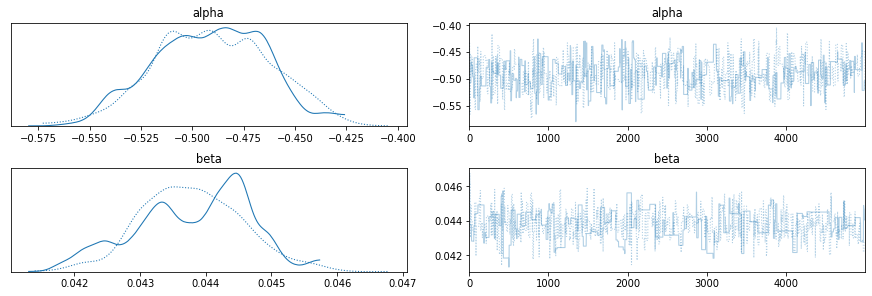

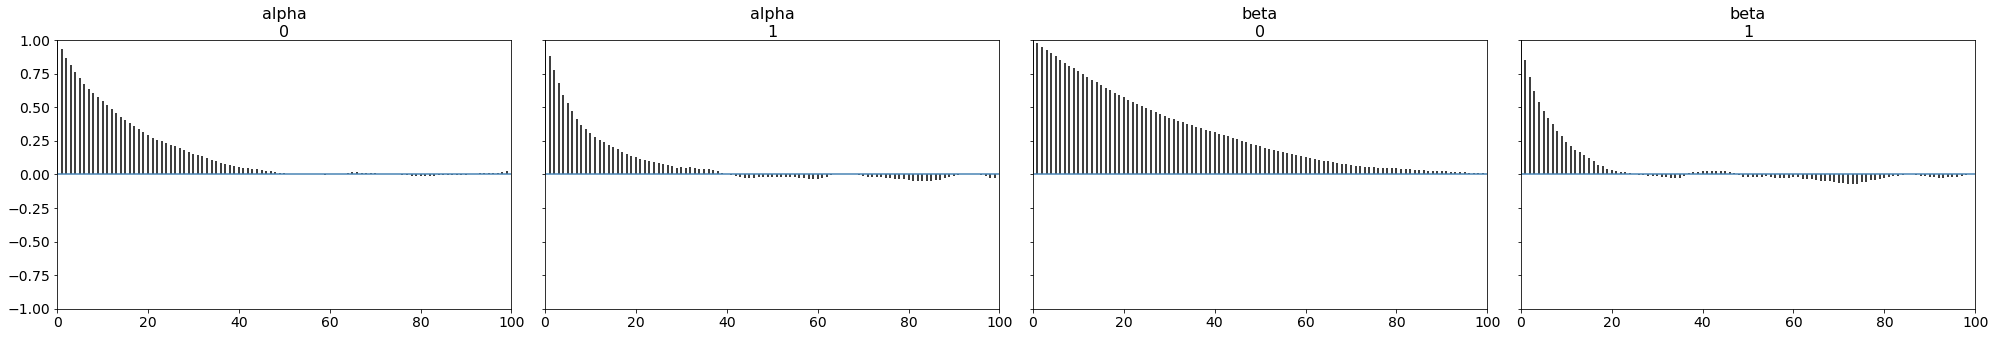

In [10]:
pm.traceplot(awake_trace, ['alpha', 'beta'])
pm.autocorrplot(awake_trace, ['alpha', 'beta'])

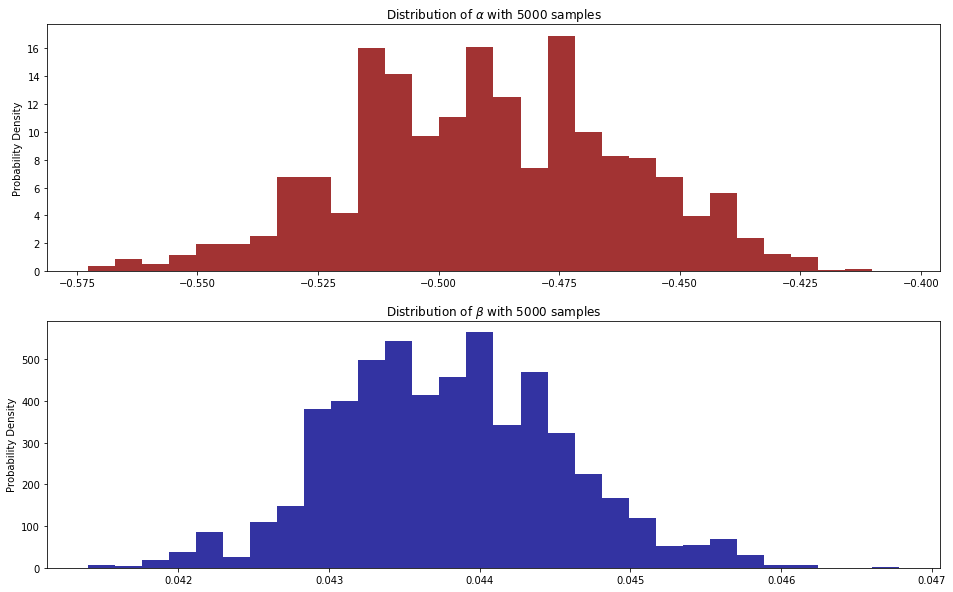

In [11]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

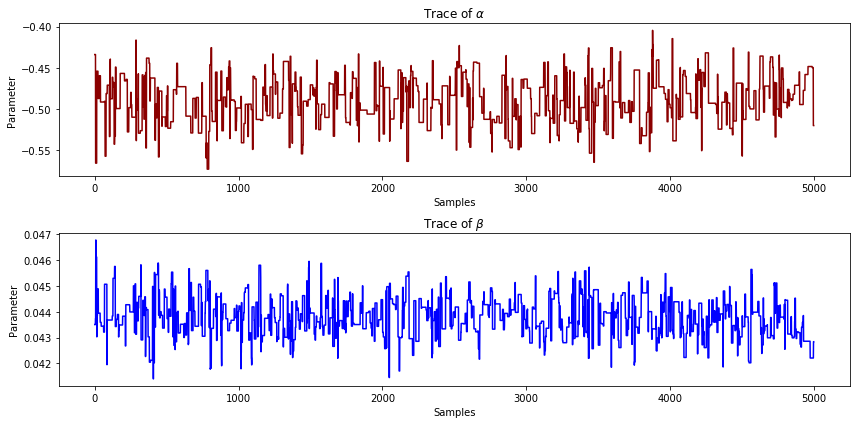

In [12]:
#trace plots
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

### Posteterior for Awake Visualization


In [13]:
#logistic probability
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [26]:
# Time values for probability prediction
time_est = np.linspace(time.min(), time.max(), 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
awake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

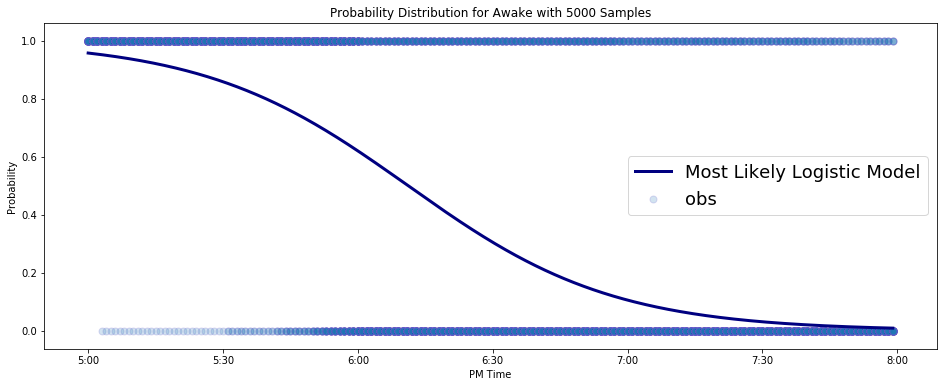

In [27]:

figsize(16, 6)
#model from MCMC sleep_est
plt.plot(time_est, awake_est, color = 'navy', 
         lw=3, label="Most Likely Logistic Model")
plt.scatter(time, wake_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Probability Distribution for Awake with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

In [29]:
print('The probability of being awake passes 50% at 6:{} AM.'.format(int(time_est[np.where(awake_est < 0.5)][0])))

The probability of being awake passes 50% at 6:11 AM.


In [34]:
print('The probability of awake passes 55% at 6:{} AM.'.format(int(time_est[np.where(awake_est < 0.55)[0][0]][0])))

The probability of awake passes 55% at 6:6 AM.


#### Probability of Awake as Function of Time

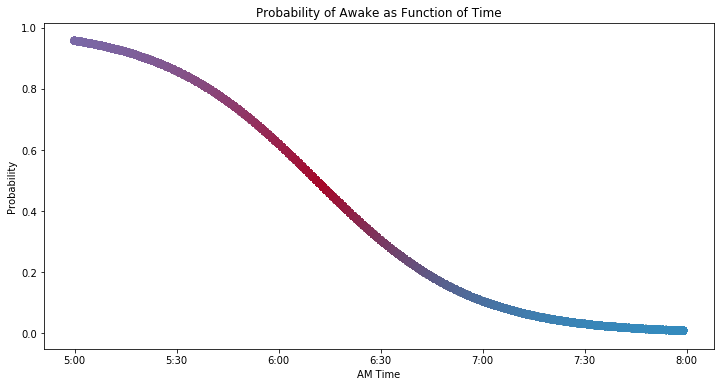

In [37]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = awake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Awake as Function of Time')
plt.xlabel('AM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

#### Investigate the Awake model

In [40]:
print('5:15 AM probability of being awake: {:.2f}%.'.
      format(100-(100 * logistic(-45, beta_est, alpha_est))))
print('6:00  AM probability of being awake: {:.2f}%.'.
      format(100-(100 * logistic(0, beta_est, alpha_est))))
print('6:30 AM probability of being awake: {:.2f}%.'.
      format(100-(100 * logistic(30, beta_est, alpha_est))))

5:15 AM probability of being awake: 7.87%.
6:00  AM probability of being awake: 37.99%.
6:30 AM probability of being awake: 69.51%.
